In [39]:
import nibabel as nib
import numpy as np
import os
import glob
from dipy.core.gradients import (gradient_table,
                                 gradient_table_from_gradient_strength_bvecs)
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import dipy.reconst.fwdti as fwdti
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib
from dipy.segment.mask import median_otsu

from dependency_injector import providers, containers
from abc import ABC, abstractmethod

In [45]:
class HandlerBase:
    """
    Base class for the Handler functions for the loading of data
    """

class LocalHandler(HandlerBase):
    """
    Class to handle the loading of local files
    """
    
    def __init__(self):
        self.dwi = None
        self.bvec = None
        self.bval = None
        self.aff = []
    
    def _get_files(self, path, end_extention):
        
        out_data = []
        
        for file in os.listdir(path):
            if file.endswith(end_extention) and \
                (not "SBRef" in file and \
                 not "BIAS" in file):
                out_data.append(os.path.join(path, file))
        
        return out_data
    
    
    def _load_dwi(self, files):
        
        data = []
        aff = []
        
        for file in files:
            loaded = nib.load(file)
            data.append(loaded.get_data())
            
        aff = loaded.affine
        
        return (data, aff)
    
    
    def _load_bvec(self, files):
        
        data = []
        for file in files:
            data.append(np.loadtxt(file))
        
        return data
    
    
    def _load_bval(self, files):
        
        data = []
        for file in files:
            data.extend(np.loadtxt(file))
        
        return data
    
    
    def _get_data(self, path, end_extention):
        
        switch = {
            ".nii.gz": self._load_dwi,
            ".bvec": self._load_bvec,
            ".bval": self._load_bval
        }
        
        paths = self._get_files(path, end_extention)
        data = switch[end_extention](paths)
        
        return data
        
    
    def load(self):
        
        dwi_path = config['dwi_path']
        bvec_path = config['bvec_path']
        bval_path = config['bval_path']
        
        dwi, af = self._get_data(dwi_path, ".nii.gz")
        bvec = self._get_data(bvec_path, ".bvec")
        bval = self._get_data(bval_path, ".bval")
        
        out = [nib.Nifti1Image(np.concatenate(dwi, -1), af),
               gradient_table(bval, np.concatenate(bvec, -1))]
        """data = []
        for d, a, bve, bva in zip(dwi, af, bvec, bval):
            data.append({
                    "dwi": d,
                    "aff": a,
                    "bvec": bve,
                    "bval": bva
                }
            )
            
        out = []
        for d in data:
            out.append({"image": nib.Nifti1Image(np.concatenate(d["dwi"], -1), d["aff"]),
                        "gradient_table": gradient_table(bval, np.concatenate(bvec,-1)),
                        })
        del data, dwi, af, bvec, bval"""
        
        return out


class HandlerProvider(providers.Factory):
    
    provided_type = HandlerBase
    

class Handler(containers.DeclarativeContainer):
    
    config = providers.Configuration('config')
    
    local_handler = HandlerProvider(LocalHandler)


class Preprocess:
    """
    Base class for the preprocessing step
    """
    pass


class Mask(Preprocess):
    """
    Wrapper for the Mask process
    """
    required = [{"image": nib.Nifti1Image, "gradient_table": gradient_table}]
    
    def _mask(self, image):
        data = image.get_data()
        maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                                     autocrop=False, dilate=1)

        axial_slice = 40
        mask_roi = np.zeros(data.shape[:-1], dtype=bool)
        mask_roi[:, :, axial_slice] = mask[:, :, axial_slice]
        
        return mask_roi
    
    def process(self, data):
        
        out = (data[0], data[1], self._mask(data[0]))
        
        return out
    
    
class PreprocessProvider(providers.Factory):
    
    provided_type = Preprocess
    
    
class PreprocessContainer(containers.DeclarativeContainer):
    
    mask = PreprocessProvider(Mask)
    

class Model(ABC):

    
    def __init__(self, gradient_table):
        self.gradient_table = gradient_table 
        self.fa = None
        self.ma = None
    
    @abstractmethod
    def fit(data, mask):
        pass


class FreeWaterTensorModel(Model):

    def __init__(self, gradient_table):
        super().__init__(gradient_table)
        self.model = None
        self.f = None
    
    def fit(self, data, mask):
        self.model = fwdti.FreeWaterTensorModel(self.gradient_table)
        self.f = self.model.fit(data.get_data(), mask=mask)
        self.FA = self.f.fa
        self.MD = self.f.md

In [52]:
dwi_file = "D:\\Users\\boywi\\Downloads\\Diffusion"
bval_file = "D:\\Users\\boywi\\Downloads\\Diffusion"
bvec_file = "D:\\Users\\boywi\\Downloads\\Diffusion"

config = {
    "dwi_path": dwi_file,
    "bvec_path": bval_file,
    "bval_path": bvec_file
}
# Delegater
handler = Handler(config=config)
lh = handler.local_handler()
data = lh.load()
masker = PreprocessContainer.mask()
data, gtab, mask = masker.process(data)

In [48]:
fwdtimodel = FreeWaterTensorModel(gtab)
fwdtimodel.fit(data, mask_roi)

FA = fwdtimodel.FA
MD = fwdtimodel.MD

In [54]:
dtimodel = dti.TensorModel(gtab)

dtifit = dtimodel.fit(data.get_data(), mask=mask_roi)

dti_FA = dtifit.fa
dti_MD = dtifit.md

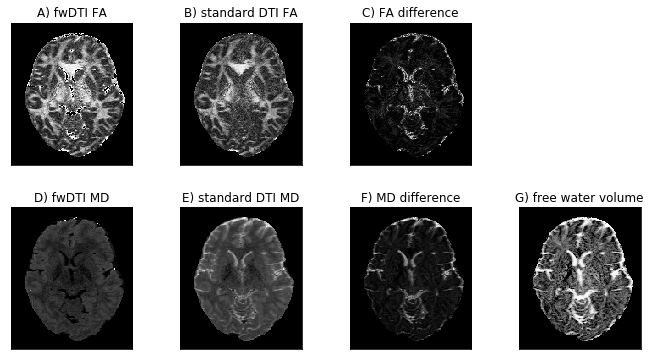

In [55]:
fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('A) fwDTI FA')
ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[1].set_title('B) standard DTI FA')

FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
ax.flat[2].imshow(FAdiff.T, cmap='gray', origin='lower', vmin=0, vmax=1)
ax.flat[2].set_title('C) FA difference')

ax.flat[3].axis('off')

ax.flat[4].imshow(MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[4].set_title('D) fwDTI MD')
ax.flat[5].imshow(dti_MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[5].set_title('E) standard DTI MD')

MDdiff = abs(MD[:, :, axial_slice] - dti_MD[:, :, axial_slice])
ax.flat[6].imshow(MDdiff.T, origin='lower', cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[6].set_title('F) MD difference')

F = fwdtifit.f

ax.flat[7].imshow(F[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[7].set_title('G) free water volume')

plt.show()